In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import statsmodels.api as sm

from sklearn.preprocessing import scale
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics 
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from tabulate import tabulate

# Ruta del archivo a trabajar
res_file_path = 'C:/Users/Toba/FCE/Big Data/Github/BigDataUBA-Grupo28/TP/TP4/Bases/respondieron.xlsx'

# Leer el archivo
df_res = pd.read_excel(res_file_path)

In [2]:
# Crear la columna 'DESOCUPADO' (1 si ESTADO es 2, 0 si no lo es)
df_res['DESOCUPADO'] = (df_res['ESTADO'] == 2).astype(int)

In [3]:
#Punto A
años = df_res['ANO4'].unique()

# Inicializar un DataFrame vacío para almacenar la diferencia de medias
diff_means_list = []

for año in años:
    # Filtrar por año
    df_año = df_res[df_res['ANO4'] == año].copy()
    
    # Limpiar CH06 (edad)
    df_año['CH06'] = df_año['CH06'].replace({
        'Menos de 1 año': 0,
        '98 y más años': 98
    }).astype(float)

    # Variables numéricas
    X_num = df_año[['CH06', 'NIVEL_ED', 'IPCF', 'CH04']]

    # Variables categóricas
    X_cat = df_año[['CH07']]  # solo estado civil

    # Transformar categóricas
    X_cat_dummies = pd.get_dummies(X_cat, drop_first=True)

    # Combinar todo
    X_final = pd.concat([X_num, X_cat_dummies], axis=1)

    # Variable dependiente
    y = df_año['DESOCUPADO']
    
    # Dividir en entrenamiento (70%) y prueba (30%)
    X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=444)
    
    # Agregar columna de unos
    X_train = pd.concat([pd.DataFrame({'ones': [1] * X_train.shape[0]}, index=X_train.index), X_train], axis=1)
    X_test = pd.concat([pd.DataFrame({'ones': [1] * X_test.shape[0]}, index=X_test.index), X_test], axis=1)
    
    # Calcular la diferencia de medias
    mean_train = X_train.mean()
    mean_test = X_test.mean()
    mean_diff = mean_train - mean_test
    
    diff_df = pd.DataFrame({
        'Media Entrenamiento': mean_train,
        'Media Prueba': mean_test,
        'Diferencia': mean_diff
    })
    
    diff_means_list.append(diff_df)

# Concatenar resultados de todos los años
diff_means_df = pd.concat(diff_means_list, keys=años)

# Mostrar resultado final
print(diff_means_df)

               Media Entrenamiento   Media Prueba    Diferencia
2004 ones                 1.000000       1.000000      0.000000
     CH06                33.451076      34.050611     -0.599535
     NIVEL_ED             2.691113       2.661867      0.029246
     IPCF               358.227007     373.852669    -15.625662
     CH04                 1.532647       1.520942      0.011705
     CH07                 3.512067       3.456370      0.055697
2024 ones                 1.000000       1.000000      0.000000
     CH06                38.205544      38.105314      0.100231
     NIVEL_ED             3.832892       3.849263     -0.016371
     IPCF            165539.752107  150432.498954  15107.253153
     CH04                 1.518647       1.533999     -0.015352
     CH07                 3.431424       3.436519     -0.005095


In [4]:
# Mapear y limpiar CH06
df_res['CH06'] = df_res['CH06'].replace({
    'Menos de 1 año': 0,
    '98 y más años': 98
}).astype(float)

# Renombrar CH06 a 'edad'
df_res = df_res.rename(columns={'CH06': 'edad'})

# 1. Crear edad2
df_res['edad2'] = df_res['edad'] ** 2

In [5]:
# Mapear CH13
map_ch13 = {
    'Sí': 1, '1': 1,
    'No': 2, '2': 2,
    'Ns./Nr.': 3, '0': 3, '0.0': 3, '9': 3
    
}

df_res['CH13'] = df_res['CH13'].replace(map_ch13)
df_res['CH13'] = pd.to_numeric(df_res['CH13'], errors='coerce').fillna(0).astype(int)

# Mapear CH12
map_ch12 = {
    'Jardín/Preescolar': 1, '1': 1,
    'Primario': 2, '2': 2,
    'EGB': 3, '3': 3,
    'Secundario': 4, '4': 4,
    'Polimodal': 5, '5': 5,
    'Terciario': 6, '6': 6,
    'Universitario': 7, '7': 7,
    'Posgrado Universitario': 8, '8': 8,
    'Educación especial (discapacitado)': 9, '9': 9, 
     '0': 0, '0.0': 0, '99': 0
}

df_res['CH12'] = df_res['CH12'].replace(map_ch12)
df_res['CH12'] = pd.to_numeric(df_res['CH12'], errors='coerce').fillna(0).astype(int)

C:\Users\Toba\AppData\Local\Temp\ipykernel_8004\3713707569.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_res['CH13'] = df_res['CH13'].replace(map_ch13)


In [6]:
import numpy as np
import pandas as pd

# Mapear CH13
map_ch13 = {
    'Sí': 1, '1': 1,
    'No': 2, '2': 2,
    'Ns./Nr.': 3, '0': 3, '0.0': 3, '9': 3
}
df_res['CH13'] = df_res['CH13'].replace(map_ch13)
df_res['CH13'] = df_res['CH13'].infer_objects(copy=False)
df_res['CH13'] = pd.to_numeric(df_res['CH13'], errors='coerce').fillna(0).astype(int)

# Mapear CH12
map_ch12 = {
    'Jardín/Preescolar': 1, '1': 1,
    'Primario': 2, '2': 2,
    'EGB': 3, '3': 3,
    'Secundario': 4, '4': 4,
    'Polimodal': 5, '5': 5,
    'Terciario': 6, '6': 6,
    'Universitario': 7, '7': 7,
    'Posgrado Universitario': 8, '8': 8,
    'Educación especial (discapacitado)': 9, '9': 9,
    '0': 0, '0.0': 0, '99': 0
}
df_res['CH12'] = df_res['CH12'].replace(map_ch12)
df_res['CH12'] = pd.to_numeric(df_res['CH12'], errors='coerce').fillna(0).astype(int)

# Asegurar que CH14 también sea numérico
df_res['CH14'] = pd.to_numeric(df_res['CH14'], errors='coerce').fillna(0).astype(int)

# Crear función para calcular años de educación
def calcular_educ_total(row):
    nivel = row['CH12']
    finalizo = row['CH13']
    ch14 = row['CH14']

    # Diccionario de años por nivel (coherente con los códigos)
    años_por_nivel = {
        1: 0,   # Jardín
        2: 7,   # Primario
        3: 9,   # EGB
        4: 12,  # Secundario
        5: 12,  # Polimodal
        6: 15,  # Terciario
        7: 17,  # Universitario
        8: 20,  # Posgrado
        9: 0    # Educación especial (no le asignamos años definidos)
    }

    # Si finalizó, tomar total del nivel
    if finalizo == 1:
        return años_por_nivel.get(nivel, np.nan)
    else:
        años_previos = años_por_nivel.get(nivel - 1, 0) if nivel > 1 else 0
        total = años_previos + ch14
        return min(total, 20)  # máximo 20 años

# Aplicar al DataFrame
df_res['educ'] = df_res.apply(calcular_educ_total, axis=1)

# Filtrar valores válidos
df_res['educ'] = df_res.apply(calcular_educ_total, axis=1)
df_res.loc[(df_res['educ'] <= 0) | (df_res['educ'] >= 98), 'educ'] = np.nan

In [7]:
# Filtrar solo los valores mayores a 0 en 'P21'
df_res = df_res[df_res['P21'] > 0].copy()  # Asegurarse de hacer una copia explícita

# Definir la tasa de inflación
inflacion = 100587.83 / 100  # 100,587.83% de inflación

# Convertir los ingresos de 2004 a 2024 usando la inflación
df_res.loc[:, 'Ingreso_2024'] = np.where(df_res['ANO4'] == 2004,
                                                           df_res['P21'] * (1 + inflacion), 
                                                           df_res['P21'])

# Asegurarse de que los ingresos en 2024 no sean negativos o muy bajos
df_res.loc[:, 'Ingreso_2024'] = df_res['Ingreso_2024'].apply(lambda x: max(x, 0))

# Calcular el salario semanal dividiendo por 40 horas a la semana
df_res.loc[:, 'salario_semanal'] = df_res['Ingreso_2024'] / 4

In [8]:
# Mapear CH09
map_ch09 = {
    'Sí, asiste': 1, '1': 1,
    'No asiste, pero asistió': 2, '2': 2,
    'Nunca asistió': 0, '3': 0
}

df_res['CH09'] = df_res['CH09'].replace(map_ch09)
df_res['CH09'] = pd.to_numeric(df_res['CH09'], errors='coerce').fillna(0).astype(int)

# Mapear CH11
map_ch11 = {
    '... público': 1, '1': 1,
    '... privado': 2, '2': 2,
    '... Ns/Nr': 9, '9': 9,
    '0': 9, '0.0': 9
}

df_res['CH11'] = df_res['CH11'].replace(map_ch11)
df_res['CH11'] = pd.to_numeric(df_res['CH11'], errors='coerce').fillna(9).astype(int)

In [9]:
# Filtrar solo los ocupados
df_ocupados = df_res[df_res['ESTADO'] == 1].copy()

# Crear variable mujer
df_ocupados['mujer'] = np.where(df_ocupados['CH04'] == 2, 1, 0)

# Quitar filas con NA en educ
df_ocupados = df_ocupados.dropna(subset=['educ'])

# Dividir en entrenamiento y prueba (70%-30%)
df_train, df_test = train_test_split(df_ocupados, test_size=0.3, random_state=444)

# Variables predictoras para entrenamiento
X1 = df_train[['edad']]  # Modelo i
X2 = df_train[['edad', 'edad2']]  # Modelo ii
X3 = df_train[['edad', 'edad2', 'educ']]  # Modelo iii
X4 = df_train[['edad', 'edad2', 'educ', 'mujer']]  # Modelo iv
X5 = df_train[['edad', 'edad2', 'educ', 'mujer', 'CH11', 'CH09']]  # Modelo v (revisar variables)

# Variable dependiente entrenamiento
y = df_train['salario_semanal']

# Añadir constante para intercepto
X1 = sm.add_constant(X1)
X2 = sm.add_constant(X2)
X3 = sm.add_constant(X3)
X4 = sm.add_constant(X4)
X5 = sm.add_constant(X5)

# Crear diccionario para resultados
resultados = {}

# Estimar cada modelo
modelos = {'Modelo i': X1, 'Modelo ii': X2, 'Modelo iii': X3, 'Modelo iv': X4, 'Modelo v': X5}

for modelo, X_data in modelos.items():
    model = sm.OLS(y, X_data).fit()
    coeficientes = model.params.round(3)
    desviacion = model.bse.round(2)
    resultados[modelo] = pd.DataFrame({'Coeficiente': coeficientes, 'Desvío estándar': desviacion})

# Mostrar resultados
for modelo, resultado in resultados.items():
    print(f"\n{modelo}:\n")
    print(resultado)


Modelo i:

       Coeficiente  Desvío estándar
const    99624.196          8469.52
edad      1023.953           196.93

Modelo ii:

       Coeficiente  Desvío estándar
const   -41312.114         22300.94
edad      8286.717          1082.10
edad2      -83.879            12.29

Modelo iii:

       Coeficiente  Desvío estándar
const  -183144.895         23306.28
edad      8534.898          1045.06
edad2      -81.887            11.87
educ     10470.562           657.91

Modelo iv:

       Coeficiente  Desvío estándar
const  -180716.156         22788.48
edad      9276.996          1023.47
edad2      -89.977            11.62
educ     11381.397           647.25
mujer   -65231.176          5134.86

Modelo v:

       Coeficiente  Desvío estándar
const  -206131.790         24677.06
edad      9487.966           972.59
edad2      -87.881            11.00
educ     14622.772           631.32
mujer   -61495.312          4837.16
CH11      1996.553          1617.27
CH09   -104097.032          5083.11


In [10]:
# Crear diccionario para resultados y modelos ajustados
resultados = {}
modelos_ajustados = {}

# Estimar cada modelo
modelos = {'Modelo i': X1, 'Modelo ii': X2, 'Modelo iii': X3, 'Modelo iv': X4, 'Modelo v': X5}

for modelo, X_data in modelos.items():
    fit = sm.OLS(y, X_data).fit()
    modelos_ajustados[modelo] = fit   # guardo modelo ajustado
    coeficientes = fit.params.round(3)
    desviacion = fit.bse.round(2)
    resultados[modelo] = pd.DataFrame({'Coeficiente': coeficientes, 'Desvío estándar': desviacion})

In [11]:
# Crear tabla vacía
tabla_final = pd.DataFrame({
    'Var. Dep: salario_semanal': ['variables', 'edad', 'edad2', 'educ', 'mujer', 'CH11', 'CH09', 'N(observaciones)', 'R2'],
    'Modelo 1': ['1'] + [''] * 8,
    'Modelo 2': ['2'] + [''] * 8,
    'Modelo 3': ['3'] + [''] * 8,
    'Modelo 4': ['4'] + [''] * 8,
    'Modelo 5': ['5'] + [''] * 8
})

# Iterar sobre los nombres de modelos
for i, nombre_modelo in enumerate(['Modelo i', 'Modelo ii', 'Modelo iii', 'Modelo iv', 'Modelo v']):
    modelo = modelos_ajustados[nombre_modelo]
    resumen = resultados[nombre_modelo]
    pvalores = modelo.pvalues.round(4)

    def format_with_stars(var):
        if var in resumen.index:
            coef = resumen.loc[var, 'Coeficiente']
            se = resumen.loc[var, 'Desvío estándar']
            pval = pvalores[var]

            if pval < 0.001:
                stars = '***'
            elif pval < 0.05:
                stars = '**'
            elif pval < 0.1:
                stars = '*'
            else:
                stars = ''

            return f"{coef:.3f}{stars} ({se:.2f})"
        else:
            return ''

    tabla_final.iloc[1, i + 1] = format_with_stars('edad')
    tabla_final.iloc[2, i + 1] = format_with_stars('edad2')
    tabla_final.iloc[3, i + 1] = format_with_stars('educ')
    tabla_final.iloc[4, i + 1] = format_with_stars('mujer')
    tabla_final.iloc[5, i + 1] = format_with_stars('CH11')
    tabla_final.iloc[6, i + 1] = format_with_stars('CH09')

    tabla_final.iloc[7, i + 1] = f"{int(modelo.nobs)}"
    tabla_final.iloc[8, i + 1] = f"{modelo.rsquared:.3f}"

# Mostrar tabla
print(tabla_final.to_string(index=False))
print("\nNotas: * p < 0.1, ** p < 0.05, *** p < 0.001")

Var. Dep: salario_semanal             Modelo 1              Modelo 2              Modelo 3                Modelo 4                 Modelo 5
                variables                    1                     2                     3                       4                        5
                     edad 1023.953*** (196.93) 8286.717*** (1082.10) 8534.898*** (1045.06)   9276.996*** (1023.47)     9487.966*** (972.59)
                    edad2                         -83.879*** (12.29)    -81.887*** (11.87)      -89.977*** (11.62)       -87.881*** (11.00)
                     educ                                            10470.562*** (657.91)   11381.397*** (647.25)    14622.772*** (631.32)
                    mujer                                                                  -65231.176*** (5134.86)  -61495.312*** (4837.16)
                     CH11                                                                                                1996.553 (1617.27)
                    

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import statsmodels.api as sm

# Variables predictoras para cada modelo
features_modelos = {
    'Modelo i': ['edad'],
    'Modelo ii': ['edad', 'edad2'],
    'Modelo iii': ['edad', 'edad2', 'educ'],
    'Modelo iv': ['edad', 'edad2', 'educ', 'mujer'],
    'Modelo v': ['edad', 'edad2', 'educ', 'mujer', 'CH11', 'CH09']
}

# Variables dependientes para train y test
y_train = df_train['salario_semanal']
y_test = df_test['salario_semanal']

# Diccionario para almacenar modelos ajustados
modelos_ajustados = {}

# Ajustar modelos solo con datos de entrenamiento
for nombre, features in features_modelos.items():
    X_train = sm.add_constant(df_train[features], has_constant='add')
    modelo = sm.OLS(y_train, X_train).fit()
    modelos_ajustados[nombre] = modelo

# Evaluar los modelos en el conjunto de prueba
resultados = []

for i, (nombre_modelo, modelo) in enumerate(modelos_ajustados.items(), start=1):
    features = features_modelos[nombre_modelo]
    X_test = sm.add_constant(df_test[features], has_constant='add')
    
    y_pred = modelo.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    resultados.append({
        "Modelo": f"Modelo {i}",
        "MSE test": mse,
        "RMSE test": rmse,
        "MAE test": mae
    })

# Mostrar tabla resumen de métricas de prueba
tabla_resultados = pd.DataFrame(resultados)
print(tabla_resultados.to_string(index=False))

  Modelo     MSE test     RMSE test      MAE test
Modelo 1 1.450157e+11 380809.271280 104537.118639
Modelo 2 1.443898e+11 379986.629640 103508.467708
Modelo 3 1.418411e+11 376617.979429 100291.055788
Modelo 4 1.406124e+11 374983.135157  98721.840874
Modelo 5 1.369515e+11 370069.648701  90692.702781


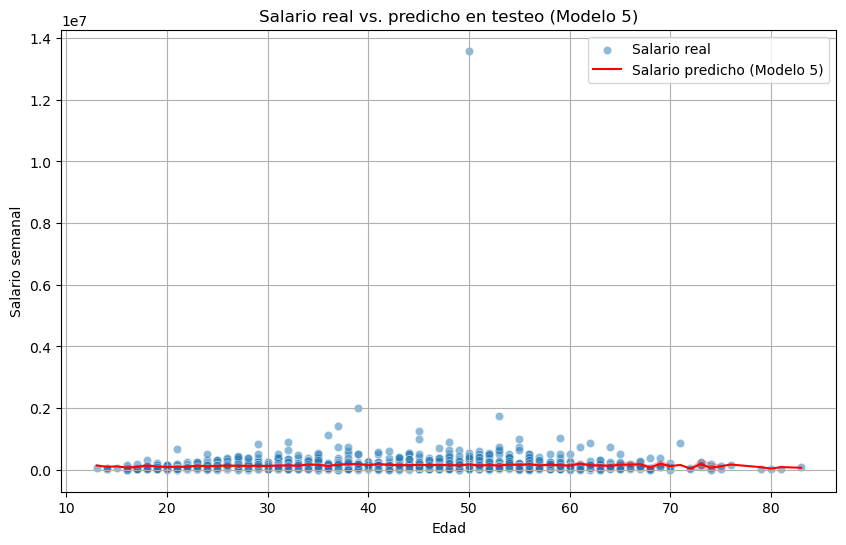

In [13]:
# Seleccionar las variables para el Modelo 5 en test
features_5 = features_modelos['Modelo v']
X_test_5 = sm.add_constant(df_test[features_5], has_constant='add')

# Obtener el modelo ajustado para Modelo 5
modelo_5 = modelos_ajustados['Modelo v']

# Predecir salarios con el Modelo 5 en test
y_pred_5 = modelo_5.predict(X_test_5)

# Crear DataFrame con edad, salario real y predicho
df_pred = df_test.copy()
df_pred['salario_predicho'] = y_pred_5

# Ordenar por edad para que la curva predicha sea suave
df_pred_sorted = df_pred.sort_values('edad')

# Graficar salario real (scatter) y salario predicho (línea)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pred, x='edad', y='salario_semanal', alpha=0.5, label='Salario real')
sns.lineplot(data=df_pred_sorted, x='edad', y='salario_predicho', color='red', label='Salario predicho (Modelo 5)')

plt.xlabel('Edad')
plt.ylabel('Salario semanal')
plt.title('Salario real vs. predicho en testeo (Modelo 5)')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Asegurarte de alinear los índices
df_train['Ingreso_2024'] = df_res.loc[df_train.index, 'Ingreso_2024']
df_test['Ingreso_2024'] = df_res.loc[df_test.index, 'Ingreso_2024']

In [17]:
# Crear copia para no modificar originales
X_train_scaled = df_train.copy()
X_test_scaled = df_test.copy()

# Columnas a escalar
cols_to_scale = ['Ingreso_2024', 'edad', 'edad2']

for col in cols_to_scale:
    non_numeric = pd.to_numeric(X_train_scaled[col], errors='coerce').isna()
    if non_numeric.any():
        print(f"Columna '{col}' tiene valores no numéricos:")
        print(X_train_scaled.loc[non_numeric, col].unique())

# Inicializar scaler
scaler = StandardScaler()

# Ajustar scaler solo con datos de entrenamiento y transformar
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train_scaled[cols_to_scale])

# Aplicar misma transformación a test
X_test_scaled[cols_to_scale] = scaler.transform(X_test_scaled[cols_to_scale])

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

logit_model = LogisticRegression()
logit_model.fit(X_train_scaled, y_train)

logit_probs = logit_model.predict_proba(X_test_scaled)[:, 1]
logit_preds = (logit_probs > 0.5).astype(int)

logit_cm = confusion_matrix(y_test, logit_preds)
logit_acc = accuracy_score(y_test, logit_preds)
logit_auc = roc_auc_score(y_test, logit_probs)
fpr_logit, tpr_logit, _ = roc_curve(y_test, logit_probs)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

knn_probs = knn_model.predict_proba(X_test_scaled)[:, 1]
knn_preds = (knn_probs > 0.5).astype(int)

knn_cm = confusion_matrix(y_test, knn_preds)
knn_acc = accuracy_score(y_test, knn_preds)
knn_auc = roc_auc_score(y_test, knn_probs)
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_probs)

print("🔹 REGRESIÓN LOGÍSTICA")
print("Matriz de confusión:\n", logit_cm)
print(f"Accuracy: {logit_acc:.4f}")
print(f"AUC: {logit_auc:.4f}\n")

print("🔹 KNN (K=5)")
print("Matriz de confusión:\n", knn_cm)
print(f"Accuracy: {knn_acc:.4f}")
print(f"AUC: {knn_auc:.4f}\n")

plt.figure(figsize=(8, 6))
plt.plot(fpr_logit, tpr_logit, label=f"Regresión Logística (AUC = {logit_auc:.2f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN (K=5) (AUC = {knn_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curvas ROC")
plt.legend()
plt.grid()
plt.show()

ValueError: could not convert string to float: 'De 6 a 40'